In [1]:
!pip install -U -q PyDrive

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
!mkdir data

In [5]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [6]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [7]:
commits = pd.io.sql.read_sql(
    "select uid, timestamp from checker where uid like 'user_%'",
    conn, parse_dates=['timestamp']
    )

In [8]:
commits.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


In [9]:
conn.close()

In [10]:
days = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

commits['weekday'] = commits['timestamp'].apply(lambda x: days[x.dayofweek])
commits['hour'] = commits['timestamp'].dt.hour
commits = commits.drop('timestamp', axis=1)

In [11]:
commits.head()

,uid,weekday,hour
0,user_4,Fri,5
1,user_4,Fri,5
2,user_4,Fri,5
3,user_4,Fri,5
4,user_4,Fri,5


In [12]:
cols = commits.groupby('uid').count().sort_values('hour', ascending=False).index

In [13]:
df_1 = commits.groupby('uid').weekday.value_counts().unstack(0)
df_1 = df_1.reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
df_1 = df_1.reindex(columns=cols)
df_1 = df_1.fillna(0)

In [14]:
df_1.head()

uid,user_4,user_14,user_2,user_25,user_19,user_26,user_20,user_31,user_10,user_3,user_29,user_13,user_28,user_24,user_12,user_8,user_1,user_21,user_30,user_18,user_17,user_16,user_27,user_15,user_6,user_7,user_22,user_11,user_23,user_0
weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mon,35.0,50.0,24.0,14.0,7.0,0.0,23.0,5.0,0.0,46.0,9.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,13.0,8.0,10.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0
Tue,86.0,87.0,131.0,44.0,9.0,1.0,0.0,0.0,16.0,11.0,26.0,57.0,7.0,14.0,1.0,0.0,0.0,16.0,3.0,0.0,4.0,5.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0
Wed,33.0,0.0,32.0,15.0,0.0,34.0,8.0,0.0,37.0,0.0,32.0,0.0,44.0,18.0,0.0,0.0,1.0,21.0,1.0,2.0,1.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0
Thu,108.0,17.0,4.0,40.0,78.0,51.0,96.0,7.0,77.0,7.0,25.0,4.0,12.0,54.0,7.0,15.0,39.0,4.0,20.0,46.0,17.0,14.0,15.0,5.0,2.0,0.0,2.0,0.0,6.0,0.0
Fri,61.0,0.0,0.0,10.0,10.0,2.0,7.0,35.0,1.0,59.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df_1.shape

(7, 30)

In [16]:
index = pd.RangeIndex(stop=24)

In [17]:
df_2 = commits.groupby('uid').hour.value_counts().unstack(0)
df_2 = df_2.reindex(index=index, fill_value=0)
df_2 = df_2.reindex(columns=cols)
df_2 = df_2.rename_axis('hour')
df_2 = df_2.fillna(0)

In [18]:
df_2.head()

uid,user_4,user_14,user_2,user_25,user_19,user_26,user_20,user_31,user_10,user_3,user_29,user_13,user_28,user_24,user_12,user_8,user_1,user_21,user_30,user_18,user_17,user_16,user_27,user_15,user_6,user_7,user_22,user_11,user_23,user_0
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_2.shape

(24, 30)

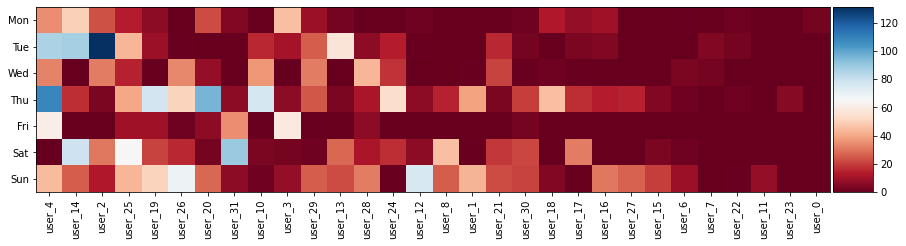

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(df_1, cmap='RdBu')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xticks(np.arange(df_1.shape[1]))
ax.set_yticks(np.arange(df_1.shape[0]))
ax.set_xticklabels(df_1.columns)
ax.set_yticklabels(df_1.index)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Больше всего коммитов во вторник у пользователя user_2, в четверг – у пользователя user_4.

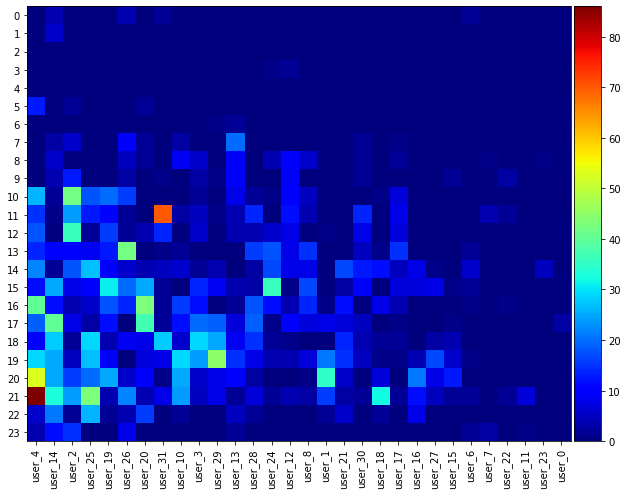

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(df_2, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xticks(np.arange(df_2.shape[1]))
ax.set_yticks(np.arange(df_2.shape[0]))
ax.set_xticklabels(df_2.columns)
ax.set_yticklabels(df_2.index)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Больше всего коммитов сделал пользователь user_4 в час 21.

In [23]:
df_1.sum(axis=1).sort_values()

weekday
Fri    196.0
Mon    257.0
Wed    286.0
Sat    505.0
Tue    526.0
Sun    665.0
Thu    772.0
dtype: float64

Меньше всего коммитов было в дни: Mon, Fri.